<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report 

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

# STEP 2 : Preparing & inspection

Prepare for inspections

In [6]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [7]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\8\8-3.png,8
1,./Thainumber\7\seven3.png,7
2,./Thainumber\3\3-5.png,3
3,./Thainumber\4\4-4.png,4
4,./Thainumber\2\two9.png,2
...,...,...
295,./Thainumber\4\4-11.png,4
296,./Thainumber\1\IMG_0862.png,1
297,./Thainumber\2\2-2.png,2
298,./Thainumber\5\five2.png,5


In [8]:
data.shape

(300, 2)

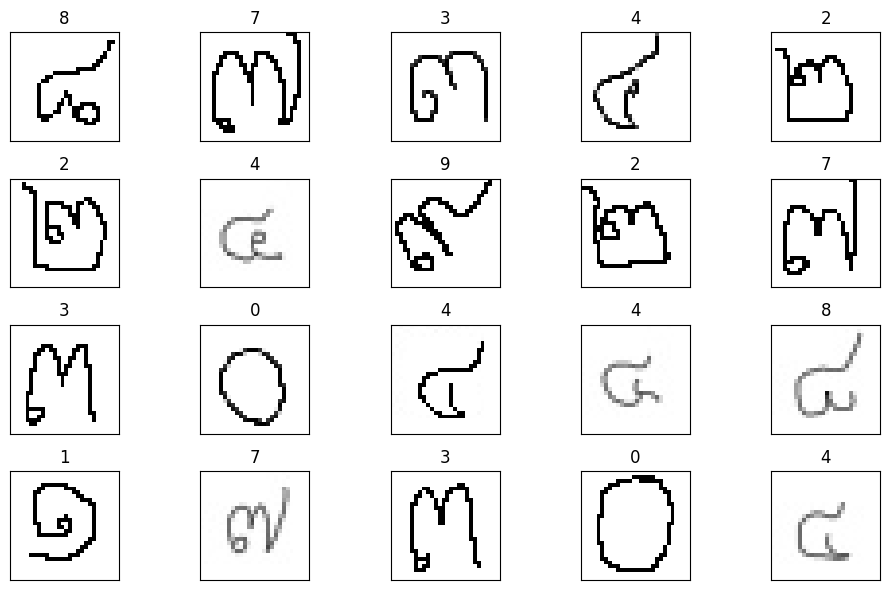

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

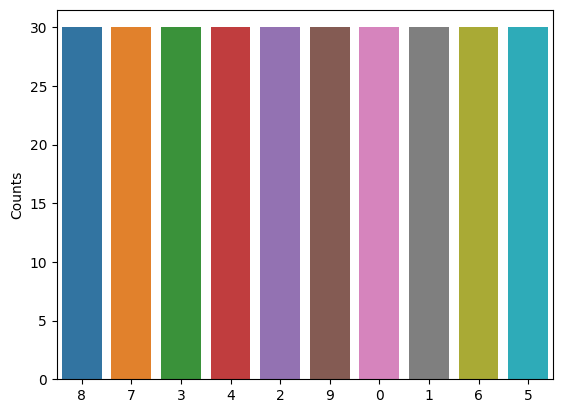

In [10]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [11]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    img_arr = img_arr.flatten()
    read_x.append(img_arr)

x = np.asarray(read_x)

In [12]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [13]:
df = pd.concat([x,y] , axis=1)
#df.to_csv('image_df.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2343,2344,2345,2346,2347,2348,2349,2350,2351,Label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,8
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,7
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,3
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,4
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,2


In [14]:
# Binarize the output

#y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
#print(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.30, random_state = 42, stratify = y )

# STEP 3 : Train 

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [16]:
from pycaret.classification import *

s = setup( df, target = 'Label', session_id = 123, train_size = 0.7  )

In [17]:
best = s.compare_models( sort = 'Accuracy', fold = 5, n_select = 3 )
pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5952,0.9250,0.5952,0.6002,0.5748,0.5503,0.5561,2.200
lr,Logistic Regression,0.5810,0.9022,0.5810,0.6162,0.5744,0.5345,0.5399,3.518
rf,Random Forest Classifier,0.5762,0.9127,0.5762,0.6041,0.5499,0.5294,0.5367,2.134
svm,SVM - Linear Kernel,0.5286,0.0000,0.5286,0.5149,0.4784,0.4763,0.4908,1.940
lightgbm,Light Gradient Boosting Machine,0.4857,0.8497,0.4857,0.5037,0.4746,0.4284,0.4326,2.528
ridge,Ridge Classifier,0.4810,0.0000,0.4810,0.5491,0.4796,0.4241,0.4298,1.938
nb,Naive Bayes,0.4667,0.7027,0.4667,0.5039,0.4542,0.4060,0.4140,2.028
gbc,Gradient Boosting Classifier,0.4238,0.8075,0.4238,0.4472,0.4096,0.3596,0.3650,6.838
lda,Linear Discriminant Analysis,0.3905,0.7632,0.3905,0.4198,0.3828,0.3225,0.3261,2.062
knn,K Neighbors Classifier,0.3571,0.7668,0.3571,0.4219,0.3428,0.2862,0.2951,2.472


In [18]:
display(best)

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        

In [19]:
tuned_model = tune_model( best[0], optimize = 'Accuracy', n_iter = 30, fold = 5 )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:01:11
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6429,0.9291,0.6429,0.7054,0.6148,0.6020,0.6102
1,0.6190,0.8951,0.6190,0.6587,0.6137,0.5760,0.5797
2,0.4524,0.9188,0.4524,0.4867,0.4352,0.3917,0.3972
3,0.5476,0.9096,0.5476,0.5765,0.5275,0.4978,0.5055
4,0.7143,0.9610,0.7143,0.6746,0.6772,0.6818,0.6871
Mean,0.5952,0.9227,0.5952,0.6204,0.5737,0.5499,0.5559
Std,0.0891,0.0222,0.0891,0.0793,0.0841,0.0985,0.0984


Fitting 5 folds for each of 30 candidates, totalling 150 fits


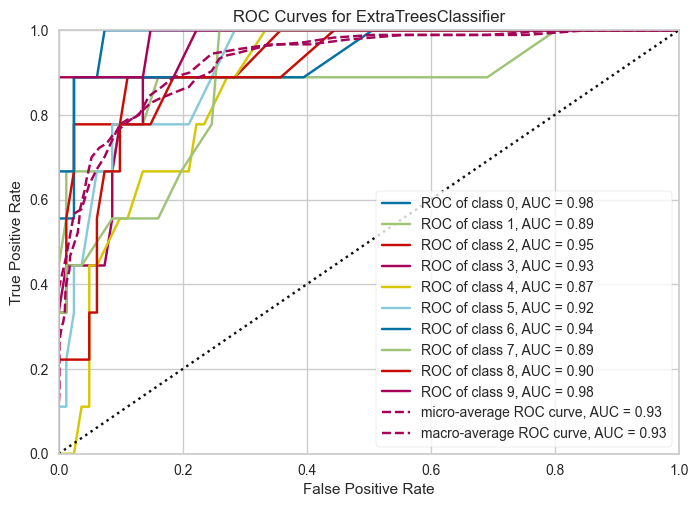

In [20]:
plot_model(tuned_model, plot = 'auc')

<h4>Pipeline</h4>

In [21]:
steps = [
    ('scalar', MinMaxScaler()),
    ('Randomforest',LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False))
]

pipeline = Pipeline(steps)

In [22]:
pr = pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))

Training score: 1.0


# STEP 4 : Test

In [23]:
y_pred = pr.predict(X_test)

print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       1.00      0.78      0.88         9
           2       0.56      0.56      0.56         9
           3       0.54      0.78      0.64         9
           4       0.67      0.44      0.53         9
           5       0.67      0.67      0.67         9
           6       1.00      0.89      0.94         9
           7       0.55      0.67      0.60         9
           8       0.90      1.00      0.95         9
           9       0.86      0.67      0.75         9

    accuracy                           0.73        90
   macro avg       0.75      0.73      0.73        90
weighted avg       0.75      0.73      0.73        90



<h4>Evaluations</h4>